# Performance Metrics for Classification 
Note: This notebook is adapted from [Geron's chapter 3 notebook](https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb) in accordance with the [Apache v2 License](https://github.com/ageron/handson-ml3/blob/main/LICENSE).

This notebook is intended for _active learning_. As a student, please run the cells as we go over them in class, and answer the questions (marked with "_to the student_") in a new cell just below each question. Also, you are invited to take notes. Once you're done, you can commit and push this updated notebook to your repository, such that you could have a copy that includes all of your changes.

### Classification

To define classification let's look at the relevant [Wikipedia article](([Wikipedia](https://en.wikipedia.org/wiki/Statistical_classification))):

>In statistics and machine learning, classification is the problem of identifying which of a set of categories (sub-populations) an observation (or observations) belongs to. Examples are assigning a given email to the "spam" or "non-spam" class, and assigning a diagnosis to a given patient based on observed characteristics of the patient (sex, blood pressure, presence or absence of certain symptoms, etc.).

>Often, the individual observations are analyzed into a set of quantifiable properties, known variously as explanatory variables or features. These properties may variously be categorical (e.g. "A", "B", "AB" or "O", for blood type), ordinal (e.g. "large", "medium" or "small"), integer-valued (e.g. the number of occurrences of a particular word in an email) or real-valued (e.g. a measurement of blood pressure). Other classifiers work by comparing observations to previous observations by means of a similarity or distance function.

>An algorithm that implements classification, especially in a concrete implementation, is known as a classifier. The term "classifier" sometimes also refers to the mathematical function, implemented by a classification algorithm, that maps input data to a category.

A list of classification algorithms can be seen on a second [Wikipedia](https://en.wikipedia.org/wiki/Category:Classification_algorithms) article.

**To the student**: summarize in your own words, based on the Wikipeida content quoted above, and potentially additional sources:
* What are we trying to solve in a classification problem?
* What is a classifier?

In this notebook, we will explore the evaluation of classifiers, rather than understanding how classifier are trained and make predictions. Evaluation of classifiers can be done by quantitative measures, often called _performance metrics_. We will look at the most common ones in this notebook. 

First let's load all of the libraries that will be used as part of this notebook:

In [65]:
import numpy as np

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows
import seaborn as sns

# The web source of the MNIST dataset that we will work with
from sklearn.datasets import fetch_openml

# The classifiers we will use in this notebook
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# cross validation functions
from sklearn.model_selection import cross_validate, cross_val_predict

# performance metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


## Obtaining the Data
We load the data from `openml.org`. [openml.org](https://openml.org/) is a public repository for machine learning data and experiments, that allows everybody to upload open datasets.The `sklearn.datasets` package is able to download datasets from the repository using the function `sklearn.datasets.fetch_openml` ([sklearn User Guide](https://scikit-learn.org/stable/datasets/loading_other_datasets.html#openml), [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html)).

**To the student**: 
* Browse to the openml website, and breifly describe what it contains based on its main landing page.
* Read the first two paragraphs in the [Wikipedia article](https://en.wikipedia.org/wiki/MNIST_database) describing MNIST. 
  * How many images does it have? 
  * What is the size of each image? 
  * Based on the image with _Sample images from MNIST test dataset_, how many unique digits does this dataset include?
* To get familiar with sklearn documentaion - browse the sklearn-doc to find out what `as_frame` stands for.

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

**To the student**: can you guess what _784_ stands for?

## Exploring the Data

The object that is returned back from `fetch_openml` is a `Bunch` object ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html)). This is a standard `sklearn` object, used for storing datasets.

In [3]:
type(mnist)

sklearn.utils._bunch.Bunch

It is a dictionary-like object, with keys and values just like a standard Python dictionary in that sense. So we can print out all of its keys:

In [4]:
list(mnist)

['data',
 'target',
 'frame',
 'categories',
 'feature_names',
 'target_names',
 'DESCR',
 'details',
 'url']

By the way, the same can be achieved by:

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

The object also contains a description of the dataset that it contains. This is provided by the curators of the dataset. It can be accessed using the `DESCR` method of the object.

In [6]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Let's look into the `data` and the `target` attributes.

In [7]:
mnist.data.shape

(70000, 784)

In [8]:
mnist.data[0,200:205]

array([  0,   0,   0,  49, 238], dtype=int64)

In [9]:
mnist.target.shape

(70000,)

In [10]:
print(mnist.target[0], mnist.target[1], mnist.target[2])

5 0 4


**To the student**: based on the examples above, as well as the info in `DESCR` and Wikipedia, can you describe:
* What `70000`, `784` stand for? 
* What do the elements of the `mnist.data` array represent (e.g. `0`, `49`)?
* What do the values in `mnist.target` represent?

Let's rename these objects to our familiar conventions, that are common regardless of the specific dataset being studied:

In [11]:
X = mnist.data
y = mnist.target

It will be good at this point to look at actual data instance, which is a single image:

In [12]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

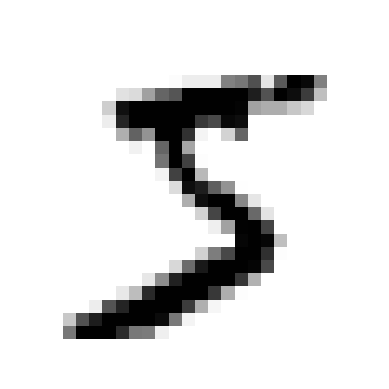

In [13]:
some_digit = X[0]  # here we are using the first image in the dataset
plot_digit(some_digit)
plt.show()

In [14]:
y[0]  # the label for the first image

'5'

For better famliarity with the dataset, let's plot the first 100 images.

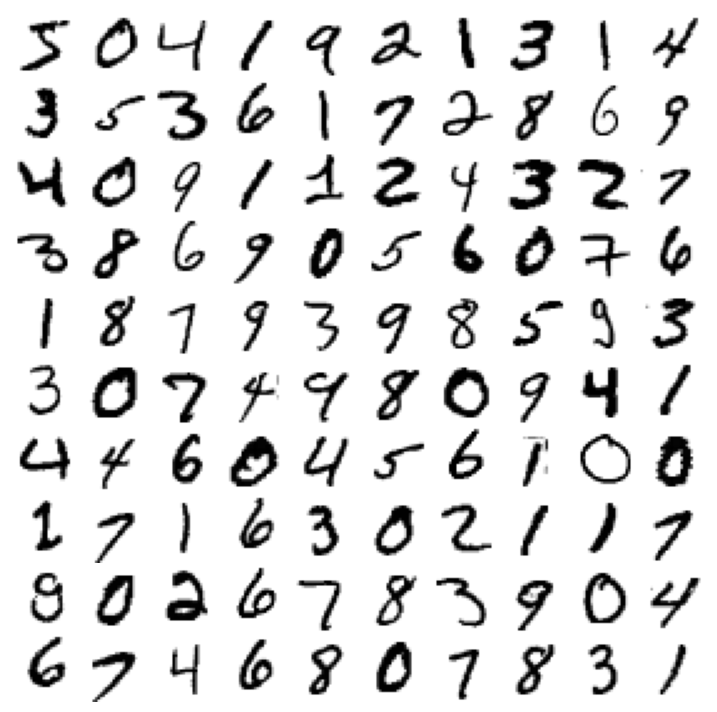

In [15]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

This provides an initial familiarity with the dataset.

An important property of a classification dataset is its skewness ([Wikipedia](https://en.wikipedia.org/wiki/Skewness)). For classification problems, the skewness is how uniform the data is in terms of the number of samples per label. In our case, it is the number of images for each digit. A uniform distribution, where each class has the same number of images, is a dataset with 0 skewness. 

**To the student**: In a new cell below, write a script that prints out the number of samples per label. Add a second Markdown cell, describing the skewness of the MNIST dataset in a sentence or two.

## Preprocessing the Data

Now, after we are familiar with the data, we can move towards preprocessing it for training. Preprocessing can include augmenting it (adding artificially similar samples, based on the existing ones), scaling it, removing outliers and such. Here we just divide the data into a train and test set, and create a new set of labels, such that the classification becomes binary, instead of 10-fold.

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [18]:
y_train_5[:5]

array([ True, False, False, False, False])

**To the student**: 
* What does the Boolean values (`True` and `False`) stand for in the target `y_train_5`?
* Why wasn't `X` changed as well?

## Training a Model

Here we are using the stocastic gradient descent classifier ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)). It provides SGD training of linear classifiers (SVM, logistic regression, etc.). However, we will not focus in this notebook on _how_ the classifer works internally, but on how well it performs. 

In [19]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Let's use this classifier to predict whether our `some_digit` is 

In [20]:
sgd_clf.predict([some_digit])

array([ True])

To the student: 
* Which image does `some_digit` stand for? (scroll above if needed)
* What is the meaning of the resulting Boolean value (`True` and `False`)?

## Evaluating the Model

### Accuracy

Let's start with `accuracy` as a performance metric. In `sklearn`, a performance metric is also known as `scoring metric`, and its value as `score`.

`Accuracy` is the ratio between correct perdictions to all predictions ([Wikipedia](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification)). 

$accuracy = \frac{correct\ classifications}{all\ classifications}$

In our case, the accuracy is calculated over the test set for each of the cross validation folds. Aaccuracy, like other performance metrics, can be calculated on any part of the complete dataset, including the traning set. So whenever we report about its value, it is informative to mention on which part of the dataset it was calculated on. 

Some optional `sklearn` resources about accuracy:

https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [21]:
cross_validate(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, scoring="accuracy")

{'fit_time': array([7.56195855, 6.98270655, 5.54786372]),
 'score_time': array([0.04580903, 0.03342414, 0.03329945]),
 'test_score': array([0.95035, 0.96035, 0.9604 ])}

**To the student**: Regarding the `cross validate` function, browse the sklearn's [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) for `cross_validate``:
* Describe in your own words what the `cv` argument is for.
* How many times has the model been trained?
* How is the value of `cv` related to the output of this function?
* What does `score_time` and `test_score` sands for?

**To the student**: Regrading the accuracy
* Could you provide a textual description of the accuracy result for the first fold? For instance "out of 100 digits, XYZ were correctly predicted, while ZYX were incorrectly predicted"
* Given the uniform distirbution of samples across all 10 digits, and given that the classifier classify one of them versus all the others (`5` versus all others in our case), what would be a simple handwritten rule to achieve 90% accuracy?
* How would you describe the goodness of classification of the `SGDClassifier` versus the expected accuracy of such a handwritten rule? Please describe it in a sentence or two. 


Following your answer to Let's look at a classifier that _ignores the features_, And see how well it will do. [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) makes predictions that ignore the input features. It is trained by guessing the next label, based on the labels it has seen so far, but without any considerations of the features (see its docs). Let's train it:

In [22]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)  # X are being ignored, see docs

DummyClassifier()

Let's see what is the accuracy of the dummy classifier:

In [23]:
cross_validate(estimator=dummy_clf, X=X_train, y=y_train_5, cv=3, scoring="accuracy")

{'fit_time': array([0.13280177, 0.12208366, 0.11772561]),
 'score_time': array([0.00100279, 0.00099945, 0.00100017]),
 'test_score': array([0.90965, 0.90965, 0.90965])}

**To the student**: 
* What is the accuracy of the `DummyClassifier`? 
* How does it compare to the handwritten rule you suggested above, and to the `SGDClassifier`? 

Let's dive deeper: 
How does the Dummy Classifier makes its perdictions? 
Well, the Dummy Classifier always returns `False`, that is it is always predicting that the digit is not `5`:

In [24]:
dummy_clf.predict(X_train)[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [25]:
# `any` is a Python function that returns True if any element of the iterable is true
print(any(dummy_clf.predict(X_train)))
print(any(dummy_clf.predict(X_test)))

False
False


**This example shows that while `accuracy` is a useful metric, it only reveals one aspect of the model performance. Additional metrics should be utilized for a more complete view.**

### Confusion Metrix

In the field of machine learning and specifically the problem of classification, a confusion matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix).

To understand what a confusion matrix is, it is useful to start with an example. Wikipedia provides us with a [good one]([Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)), let's go over it together...


In a binary classification, for a single prediction of one sample, there are 4 possible options for the prediction with respect to the _target label_ (`5` in our example, the target can be chosen from the two labels, based on our interest, based for instance on the main objective of the classifier):

the positive class is one of the two classes in a binary classification problem. It is the class that the model is trying to predict. The choice of which class is considered positive and which is considered negative is often arbitrary and depends on the context of the problem. For example, in a medical test for a disease, the positive class could be “disease present” and the negative class could be “disease not present”.

There are two types of correct predictions:
* **True Positive** - the prediction is of the target class, and that is correct (according to the ground truth). 
* **True Negative** - the prediction is not of the target class, and this is correct.

There are two types of incorrect predictions:
* **False Positive** - the prediction is of the target class, and this is incorrect (according to the ground truth).
* **False Negative** - the prediction is not of the target class, and this is incorrect

The confusion matrix is a table:
* Each row stands for an actual label (going over all labels in the dataset, one row per label)
* Each column stands for a predicted label (going over all labels in the dataset, one row per label)
* Each cell in the table simply counts the number of samples in the dataset that had such a predicted-actual combination. This can be augmented by a percentage, where this number is divided by the total number of samples in the dataset.

In `sklearn`, the default order of the labels in the confusion matrix is based on a sort over all unique labels in both the ground-truth and prediction labels (see the `labels` parameter in the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).

Note that to generate a confusion table, one need to know only the prediction and actual labels of a given dataset. The classifier that generated this predictions is irrelevant for the generation of the matrix.

In [26]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [27]:
y_train_pred.shape

(60000,)

In [28]:
y_train_pred[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [29]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [30]:
cm.sum()

60000

To better understand confusion matrix, let's generate perfect dummy predictions:

In [31]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

To the student: Using `sklearn` resources about Confusion Matrix: [docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [user guide](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix):

* What are the required arguments that the `confusion_matrix` function expects?
* What is the output of this function, specifically for a binary classifier such as the one tested here?
* What is the meaning of each value in both of the confusion matrics returned above?

### Precision and Recall

In classification, precision and recall are additional performance metrics ([Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)).
They are calculated and presented with respect to the 'class of interest'. This class can be any one that we are interested in calculating precision and recall for. It depends on the success criteria that we have defined for the model. For instance, if the model should identify a risk of an illness based on a medical test results, the class of interest would probably be existence of such medical condition. We call this class of interest as the _positive class_. 

* Precision is ratio of the number of correctly labelled positive samples, out of all samples labelled as positive samples. It tells us how precise the model is in predicting a positive class. This is equal to: $precision = \frac{True \ Positives}{True \ Positives + False \ Positives}$. Since precision and recall are often used in estimating the relevance of search results (think Google), precision is sometimes defined as 'the fraction of relevant instances among the retrieved instances', which stands for the same ratio.
* Recall (also known as sensitivity) is the number of correctly labelled positive samples, out of all positive samples in the test dataset $Recall = \frac{True \ Positives}{True \ Positives + False \ Negatives}$. It tells us how many samples of the 'class of interest' the model is able to identify, out of all samples. That is, how many it is able to recall. In the search relevnce jargon, this is described as the ratio of relevant instances that were retrieved, but the formula is the same.

Note that it is possible to calculate precision and recall for more than one class. If there is a need to present either precision or recall for more than one class, one can do that without issue.

The _precision and recall_ image in Wikipedia is an effective way to understand these definitions. 

See also [SKLearn User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)



In [32]:
precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [33]:
# This cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [34]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**To the student**: 
* Similar to the manual calculation of precision, in a new cell below, write down the Python code for calculating recall

#### F1-score

It can be useful to compare classifiers based on a single number, that encompases both precision and recall. F1-score is a common such performance metrix. 

The F-score is calculated from the precision and recall of the test. The F1 score is the harmonic mean of the precision and recall (harmonic mean is the average of rates ([Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean)), see more below). The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either precision or recall are zero. ([Wikipedia](https://en.wikipedia.org/wiki/F-score)). Whereas the regular (arithmetic) mean treats all values equally, the harmonic mean gives more weight to low values. As a result, the classifier will only get a high F1  score if both recall and precision are high.

$F1 \ score = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FP+FN}{2}}$

Notice that the F1 score is independent of True Negatives (TN) ([Wikipedia](https://en.wikipedia.org/wiki/F-score#Criticism)).

Calculating F1 score can be done in `sklearn` with the predictions and ground truth as inputs:

In [35]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**To the student**: 
* Using the [definition](https://en.wikipedia.org/wiki/F-score#Definition) calculate the F1 score that was generated above, using True Positives (TP), False Negatives (FN) and False Positives (FP). Write this as a Python code in a new cell below.

#### Side Note: Comparing a Harmonic Mean to an Arithmetic ('conventional') Mean

* For two ratios (values between 0 and 1), such as precision and recall, harmonic mean is lower than the arithmetic mean.
* The largest difference between the two means is when there is a large difference between the two ratios.

By examining the graphs presented below, it becomes evident that choosing the F1 score as our metric, instead of an arithmetic mean, favors achieving high precision and recall simultaneously, rather than favoring one at the expense of the other.

To read more about the three types of means (arithmetic, geometric and harmonic), see [Wikipedia](https://en.wikipedia.org/wiki/Pythagorean_means) about the Pythagorean means.

Harmonic mean is a useful type of mean for many real-world situations, see for instance the calculation of the mean speed of a vehicle ([Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean#Average_speed)). The harmonic mean is also used for calculating the actual resistance of two resistors connectted in parallel, and for many other cases.

Text(0.5, 1.0, 'Arithmetic (conventional) Mean')

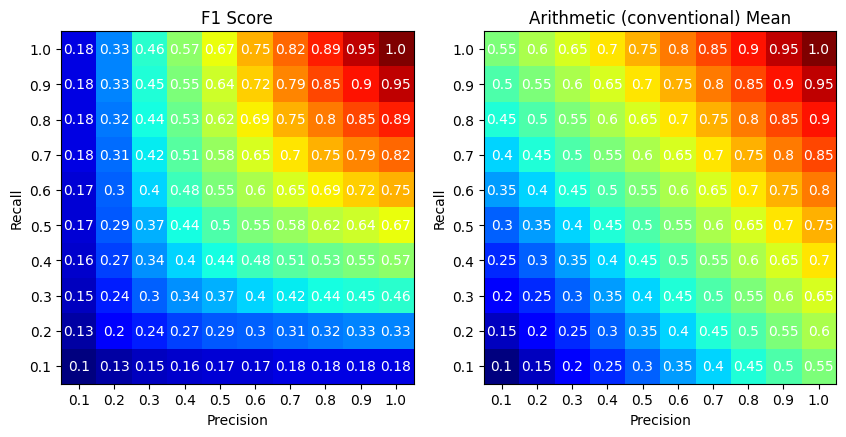

In [36]:
precision = np.round(np.linspace(0.1, 1, 10), 2)
recall = np.round(np.linspace(1, 0.1, 10), 2)

# create a mesh grid of precision and recall
precision_grid, recall_grid = np.meshgrid(precision, recall)

f1_score_calc = np.round(2 * (precision_grid * recall_grid) / (precision_grid + recall_grid), 2)
arithmetic_mean = np.round((precision_grid + recall_grid) / 2, 2)

# plot a color map of the F1 score
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

im1 = axes[0].imshow(f1_score_calc, cmap="jet")
axes[0].set_xticks(np.arange(len(precision)), precision)
axes[0].set_yticks(np.arange(len(recall)), recall)
# Loop over data dimensions and create text annotations.
for i in range(len(precision)):
    for j in range(len(recall)):
        text = axes[0].text(j, i, f1_score_calc[i, j],
                       ha="center", va="center", color="w")
axes[0].set_xlabel("Precision")
axes[0].set_ylabel("Recall")
axes[0].set_title("F1 Score")

im2 = axes[1].imshow(arithmetic_mean, cmap="jet")
axes[1].set_xticks(np.arange(len(precision)), precision)
axes[1].set_yticks(np.arange(len(recall)), recall)
# Loop over data dimensions and create text annotations.
for i in range(len(precision)):
    for j in range(len(recall)):
        text = axes[1].text(j, i, arithmetic_mean[i, j],
                       ha="center", va="center", color="w")
axes[1].set_xlabel("Precision")
axes[1].set_ylabel("Recall")
axes[1].set_title("Arithmetic (conventional) Mean")


Text(0.5, 1.0, 'Arithmetic mean - F1 Score')

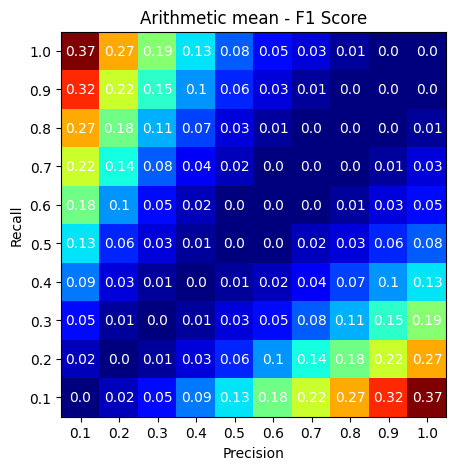

In [37]:
# plot a color map of the F1 score
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)

diff = np.round(arithmetic_mean - f1_score_calc, 2)

im1 = ax.imshow(diff, cmap="jet")
ax.set_xticks(np.arange(len(precision)), precision)
ax.set_yticks(np.arange(len(recall)), recall)
# Loop over data dimensions and create text annotations.
for i in range(len(precision)):
    for j in range(len(recall)):
        text = ax.text(j, i, diff[i, j],
                       ha="center", va="center", color="w")
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_title("Arithmetic mean - F1 Score")


### Precision/Recall Tradeoff, and the Decision Threshold

For a given trained classifier (without a new training), it is possible to increase the either the precision or the recall on the expense of the other. This is called the precision/recall tradeoff (note that a different classifier altogether could in principle increase both. The tradeoff is relevant only for a given classifier with a specific set of paramters).


Here, we will change the decision threshold of our binary classifier, which will change its precision and recall, without any additional training.

**To the student**: 
* Assume that you are developing an ML classifeir for medical diagnostics, with the propose of being a first indicator to identify whether a patient has a medical condition that requires treatment or not. Based on this result, the data wil be delivered to a medical professional or not (this might not be a great practice, but let's assume it for the sake of the example). What would be better, a high precision or a high recall? 
* Likewise, what would be better to optimize for (a high precision versus recall), when an ML classifier should highlight the best investment opportunities in a stock exchange?
* Add two more real-world cases in which:
  * Would a high recall will be desired, even on the expense of a lower precision? 
  * And when would a high precision will be preferred, on the expense of a lower recall? 


In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In Scikit-learn, the `decision_function` method is a method that is available for some classifiers, such as SVMs and logistic regression models. **It returns the "distance" of each data point to the decision boundary of the classifier.**

For binary classification, the decision boundary is a hyperplane that separates the two classes. The `decision_function` method returns the signed distance of each data point to this hyperplane. The sign of the distance indicates which side of the hyperplane the data point is on, and the magnitude of the distance indicates how far the data point is from the hyperplane.

For example, if the `decision_function` method returns a value of 2 for a particular data point, this means that the data point is on the positive side of the decision boundary and is 2 units away from the boundary. If the method returns a value of -1 for another data point, this means that the data point is on the negative side of the decision boundary and is 1 unit away from the boundary.

The `decision_function` method can be useful for analyzing the confidence of the classifier's predictions. Data points with larger absolute values of the decision function are farther from the decision boundary and are more confidently classified than data points with smaller absolute values.

A classification is made by comparing the decision function value to a threshold.
For instance:

In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


Changing the threshold changes the prediction:

In [40]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [42]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

The SKLearn's [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function computes precision-recall pairs for different probability thresholds. 

* Note: this implementation is restricted to the binary classification task.
* The first precision and recall values are precision=class balance and recall=1.0 which corresponds to a classifier that always predicts the positive class.
* The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold. This ensures that the graph starts on the y axis.

In [43]:
print(precisions.shape)
print(recalls.shape)
print(thresholds.shape)

(60001,)
(60001,)
(60000,)


In [64]:
print(precisions[:5])
print(recalls[:5])
print(thresholds[:5])


[0.09035    0.09035151 0.09035301 0.09035452 0.09035602]
[1. 1. 1. 1. 1.]
[49442.43765905 49441.43765905 36801.60697028 35987.20307515
 34662.20950045]


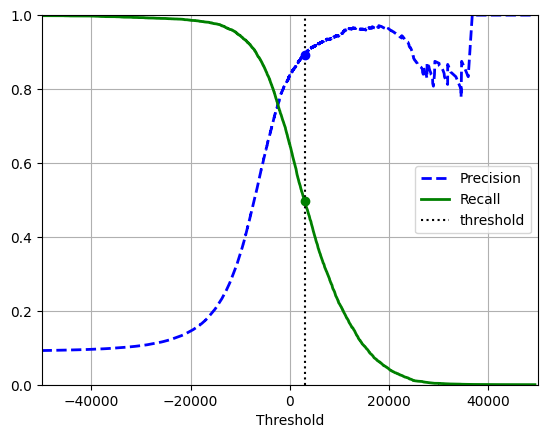

In [44]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

**To the student**: 
* How do precision and recall change with increasing or decreasing the threshold? 
* What is the intuition behind this behavior?

Below we use the same data, but to plot a Precision-Recall curve.
This is a useful curve for choosing a threshold. 

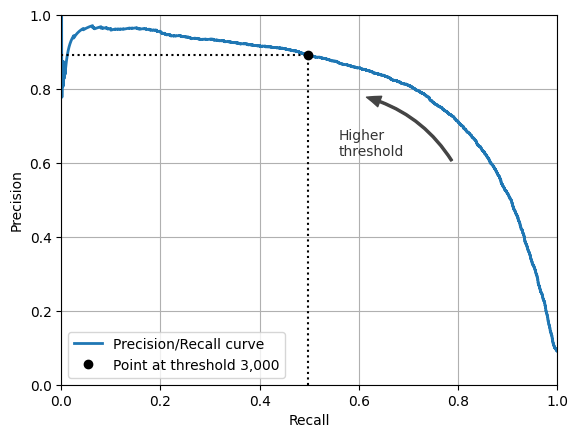

In [45]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

Let's find the threshold for a 90% precision:

In [46]:
idx_for_90_precision = (precisions >= 0.90).argmax()  # argmax returns the first index of the maximum value. In this case, the first True value.
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To validate, we can now run predictions based on the classifier's scores and the new thresholds, and to re-calculate the precision:

In [47]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

And here is the recall for that threshold:

In [49]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

The Receiver Operating Characteristic (ROC) curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is the plot of the _true positive rate (TPR)_ against the _false positive rate (FPR)_, at various threshold settings ([Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)).

* **True Positive Rate (TPR)** - this is _recall_, also known as _sensitivity_: $TPR = Sensitivity = Recall = \frac{True \ Positives}{True \ Positives + False \ Negatives}$ ([Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity))
* **False Positive Rate (FPR)** - also known as "false alarm rate" or "fall-out": $FPR = \frac{False \ Positives}{False \ Positives + True \ Negatives}$ ([Wikipedia](https://en.wikipedia.org/wiki/False_positive_rate))

An ideal classifier would have a TPR=1 and a FPR=0.

The ROC curve was first developed by electrical engineers and radar engineers during World War II for detecting enemy objects in battlefields, starting in 1941, which led to its name ("receiver operating characteristic"). It was soon introduced to psychology to account for perceptual detection of stimuli. ROC analysis since then has been used in many other fields.

To calculate the ROC curve we use the `roc_curve` function by SKLearn ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html), [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics0))

In [50]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

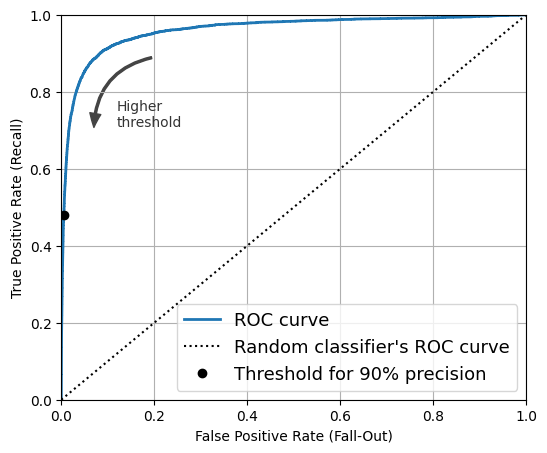

In [51]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.
We can calculate the Area Under the Curve (AUC) of the ROC curve, in order to see how 'resiliant' the classifier is for changing threshold. The larger the value, the more resiliant the classifier.

For this we can use the `roc_auc_score` function by SKLearn ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html))

In [52]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### ROC, Precision-Recall or Both - Which One to Use?
* Use Precision-Recall curve whenever the positive class is rare or when you care more about the false positives than the false negatives. 
* Otherwise, use the ROC curve. 

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s; 10%) compared to the negatives (non-5s; 90%). In contrast, the precision-recall curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner.

#### Comparison of Classifiers Based on Precision-Recall Curve

Below we define a new classifier, based on random forest. Without going into the intrinsic details of how it works, let's train it and evaluate its performance, compared to the `SGDClassifier` that we trained above.

**Warning:** the following cell may take a few minutes to run.

In [53]:
forest_clf = RandomForestClassifier(random_state=42)

We ask to return the prediction probabilities, instead of the actual binary prediction, such that we can have the option to set the class predictions using a threshold of our choice. This allows us to plot the precision-recall curve.

In [54]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let's print the probabilities for the first two images in the training set, based on the cross validation process:

In [55]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

Check: Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images:

In [56]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


With this probabilities we can plot the precision-recall curve

In [57]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

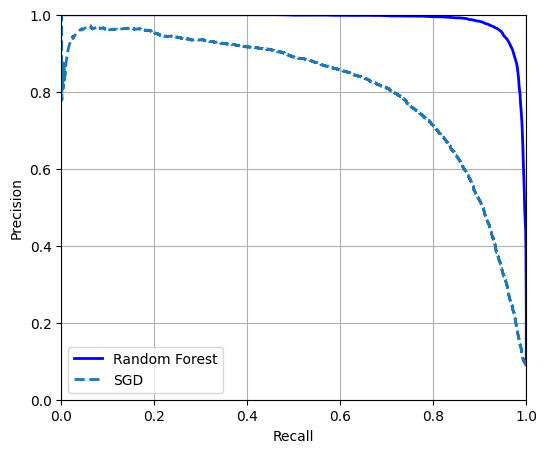

In [58]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [59]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [61]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [62]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402